In [1]:
# import
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression  # Import LogisticRegression for the StackingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import joblib

In [2]:

# Load the dataset containing labeled emails (spam and non-spam)
data = pd.read_csv('data/email3.csv')


In [3]:
# Ensure that the 'Body' column contains only strings (not floats)
data = data.dropna(subset=['Body'])
data['Body'] = data['Body'].astype(str)
data.loc[6043,'Body']

'IN THIS ISSUE:01. Readers write\r\n02. Extension search\r\n03. Dumb messages revisited\r\n04. XP Tweak\r\n05. Hardware Diagnostic Tool\r\n06. Training Windows\r\n07. Hold that button\r\n08. Hagai\'s freeware\r\n09. Online helpAnd Coming Next Week!<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>\r\nMake Internet Explorer Faster, More Capable, and Secure! \r\nNNT\'s reviewers called Secure IE great, easy-to-use,awesome,\r\nimpressive, a total "thumbs up"!  Read what they\'re raving \r\nabout and get yours at http://www.secureie.com/p/nnt1/\r\n<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>01. READERS WRITE.  A Wisconsin subscriber wrote to express his displeasure \r\nwith the links contained in Neat Net Tricks.  It seems he is bothered by \r\nthe frequent pop-up ads and he felt that only those sites without the ads \r\nshould be featured in NNT, particularly in the Premium issue. We replied \r\nthat pop-ups can be annoying but, while not defending them, we must 

In [4]:
data.head()

,Unnamed: 0,Body,Label
0,0,\r\nSave up to 70% on Life Insurance.\r\nWhy S...,1
1,1,1) Fight The Risk of Cancer!\r\nhttp://www.adc...,1
2,2,1) Fight The Risk of Cancer!\r\nhttp://www.adc...,1
3,3,##############################################...,1
4,4,I thought you might like these:\r\n1) Slim Dow...,1


In [5]:
data.info

<bound method DataFrame.info of       Unnamed: 0                                               Body  Label
0              0  \r\nSave up to 70% on Life Insurance.\r\nWhy S...      1
1              1  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
2              2  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
3              3  ##############################################...      1
4              4  I thought you might like these:\r\n1) Slim Dow...      1
...          ...                                                ...    ...
6041        6041                                              empty      0
6042        6042                    ___           ___           ...      0
6043        6043  IN THIS ISSUE:01. Readers write\r\n02. Extensi...      0
6044        6044                                              empty      0
6045        6045                                              empty      0

[6045 rows x 3 columns]>

In [6]:
data= data.dropna()

In [7]:
data.info

<bound method DataFrame.info of       Unnamed: 0                                               Body  Label
0              0  \r\nSave up to 70% on Life Insurance.\r\nWhy S...      1
1              1  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
2              2  1) Fight The Risk of Cancer!\r\nhttp://www.adc...      1
3              3  ##############################################...      1
4              4  I thought you might like these:\r\n1) Slim Dow...      1
...          ...                                                ...    ...
6041        6041                                              empty      0
6042        6042                    ___           ___           ...      0
6043        6043  IN THIS ISSUE:01. Readers write\r\n02. Extensi...      0
6044        6044                                              empty      0
6045        6045                                              empty      0

[6045 rows x 3 columns]>

In [8]:

# Text preprocessing function for emails
def preprocess_email(text):
    # Customize email text preprocessing here
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove email headers, signatures, and other specific email content
    # You may need to implement custom logic for this
    
    # Remove punctuation and numbers
    text = ''.join([char for char in text if char not in string.punctuation and not char.isdigit()])
    
    # Tokenization (split text into words)
    tokens = word_tokenize(text)
    
    # Remove stopwords (common words like "the", "and", "is")
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Rejoin tokens into a single string
    text = ' '.join(tokens)
    
    return text

In [9]:
# Apply text preprocessing to the 'Body' column
data['Body'] = data['Body'].apply(preprocess_email)

In [10]:


# Create a TF-IDF vectorizer to convert email text data into feature vectors
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['Body'].values)
y = data['Label'].values
joblib.dump(vectorizer, 'emailTfidfVectorizer.sav')

['emailTfidfVectorizer.sav']

In [11]:

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base classifiers
random_forest = RandomForestClassifier()
svm_classifier = SVC(probability=True)
logistic_regression = LogisticRegression()

# Define stacking classifier with base classifiers
stacking_classifier = StackingClassifier(
    estimators=[
        ('Random Forest', random_forest),
        ('SVM', svm_classifier),
        ('Logistic Regression', logistic_regression)
    ],
    final_estimator=LogisticRegression()
)

# Define a VotingClassifier combining base classifiers
voting_classifier = VotingClassifier(
    estimators=[
        ('Random Forest', random_forest),
        ('SVM', svm_classifier),
        ('Logistic Regression', logistic_regression),
        ('Stacking', stacking_classifier)  # You can include stacking as one of the voters
    ],
    voting='hard'  # You can use 'soft' or 'hard' voting
)

# Fit the stacking classifier
stacking_classifier.fit(X_train, y_train)

# Make predictions on the test set
stacking_predictions = stacking_classifier.predict(X_test)

# Fit the voting classifier
voting_classifier.fit(X_train, y_train)
joblib.dump(voting_classifier, 'emailmodel.sav')
# Make predictions on the test set
voting_predictions = voting_classifier.predict(X_test)

# Calculate evaluation metrics for the stacking classifier
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
stacking_precision = precision_score(y_test, stacking_predictions)
stacking_recall = recall_score(y_test, stacking_predictions)
stacking_f1 = f1_score(y_test, stacking_predictions)
stacking_confusion = confusion_matrix(y_test, stacking_predictions)

# Calculate evaluation metrics for the voting classifier
voting_accuracy = accuracy_score(y_test, voting_predictions)
voting_precision = precision_score(y_test, voting_predictions)
voting_recall = recall_score(y_test, voting_predictions)
voting_f1 = f1_score(y_test, voting_predictions)
voting_confusion = confusion_matrix(y_test, voting_predictions)

# Print evaluation metrics for the stacking classifier
print("Stacking Metrics:")
print("Accuracy:", stacking_accuracy)
print("Precision:", stacking_precision)
print("Recall:", stacking_recall)
print("F1-Score:", stacking_f1)
print("Confusion Matrix:")
print(stacking_confusion)

# Print evaluation metrics for the voting classifier
print("\nVoting Metrics:")
print("Accuracy:", voting_accuracy)
print("Precision:", voting_precision)
print("Recall:", voting_recall)
print("F1-Score:", voting_f1)
print("Confusion Matrix:")
print(voting_confusion)

Stacking Metrics:
Accuracy: 0.9470636889991728
Precision: 0.8930232558139535
Recall: 0.9552238805970149
F1-Score: 0.923076923076923
Confusion Matrix:
[[761  46]
 [ 18 384]]

Voting Metrics:
Accuracy: 0.9478908188585607
Precision: 0.9026128266033254
Recall: 0.945273631840796
F1-Score: 0.9234507897934386
Confusion Matrix:
[[766  41]
 [ 22 380]]


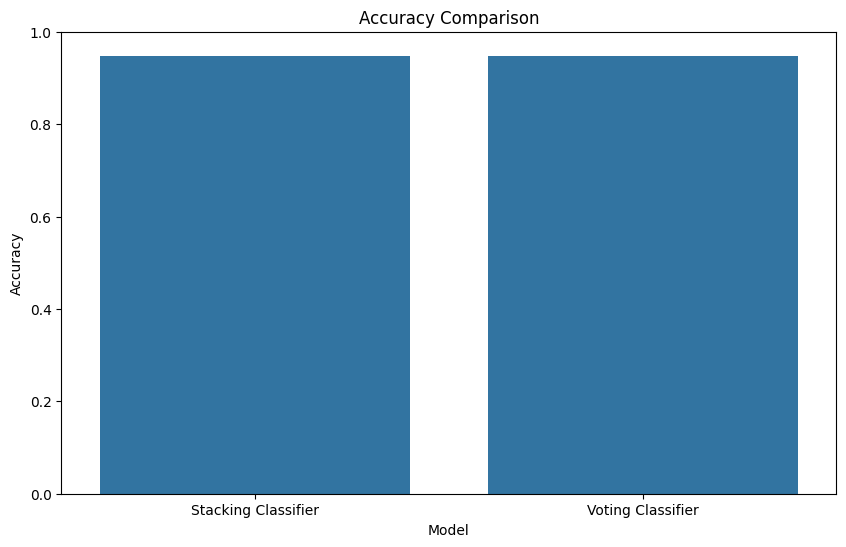

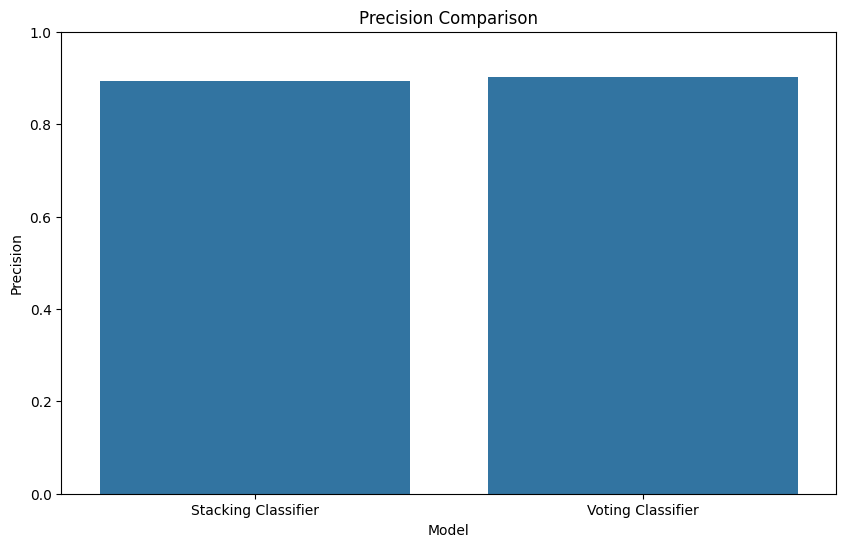

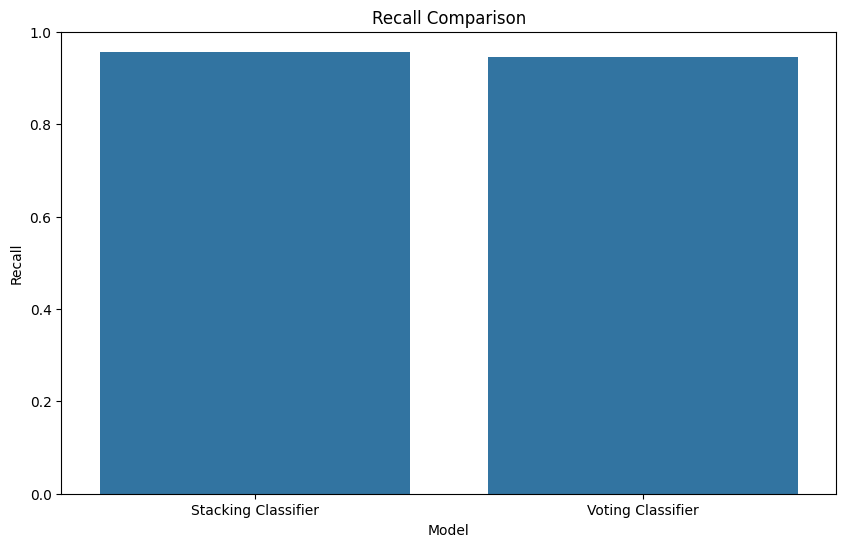

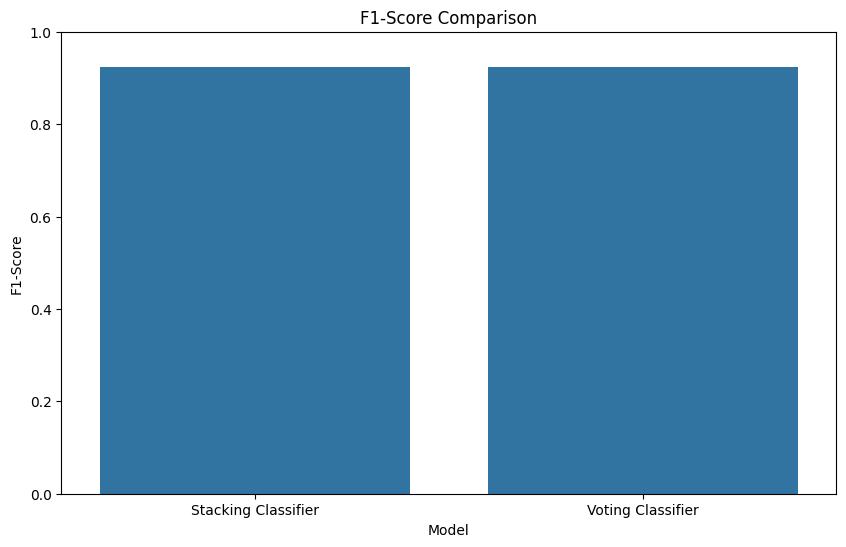

<Figure size 1200x600 with 0 Axes>

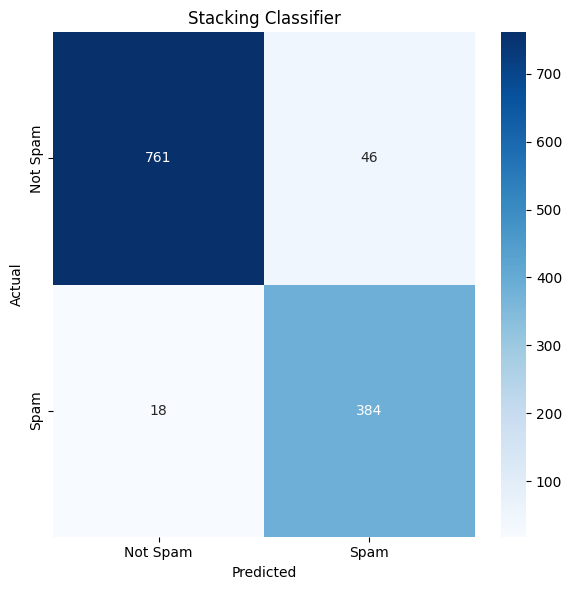

<Figure size 1200x600 with 0 Axes>

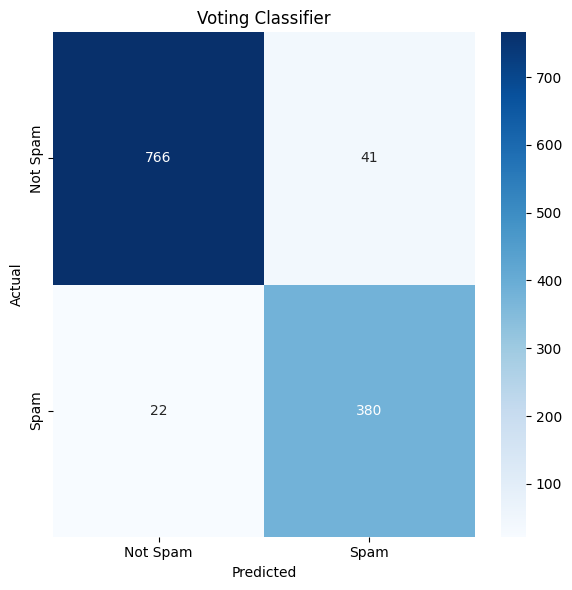

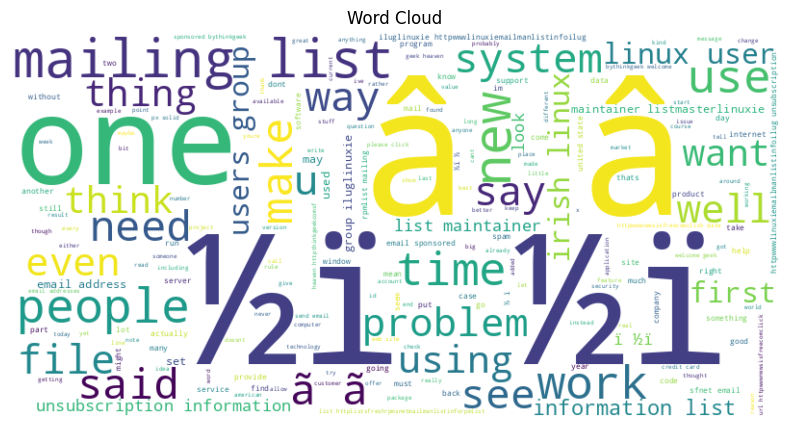

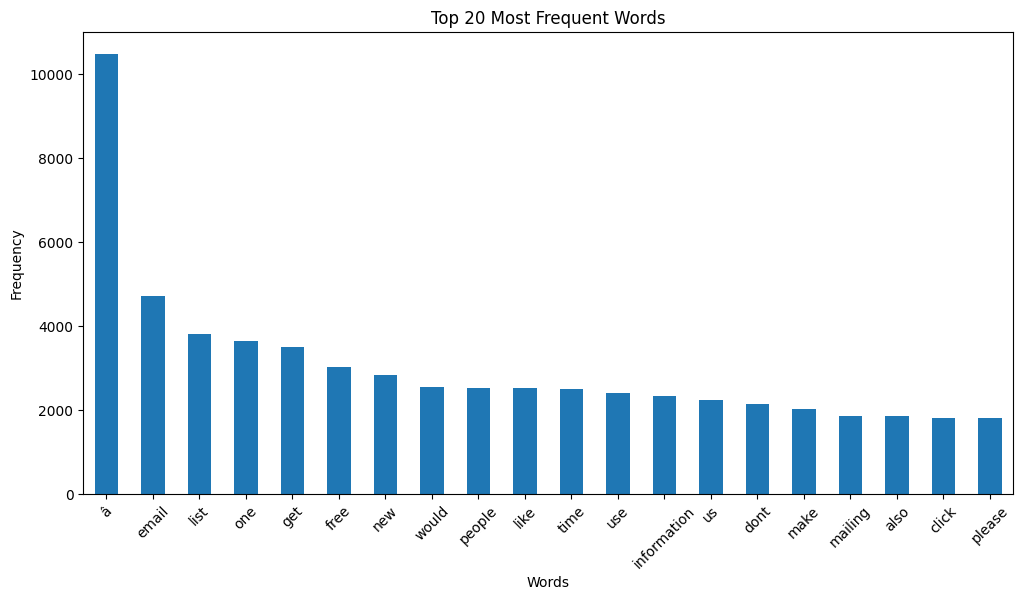

In [12]:
# Visualize performance metrics using Seaborn
metrics_data = {
    'Model': ['Stacking Classifier', 'Voting Classifier'],
    'Accuracy': [stacking_accuracy, voting_accuracy],
    'Precision': [stacking_precision, voting_precision],
    'Recall': [stacking_recall, voting_recall],
    'F1-Score': [stacking_f1, voting_f1]
}

metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision', data=metrics_df)
plt.title('Precision Comparison')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=metrics_df)
plt.title('Recall Comparison')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=metrics_df)
plt.title('F1-Score Comparison')
plt.ylim(0, 1)
plt.show()

# Visualize confusion matrices using Seaborn
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)

plt.figure(figsize=(12, 6))
plot_confusion_matrix(stacking_confusion, ['Not Spam', 'Spam'], 'Stacking Classifier')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plot_confusion_matrix(voting_confusion, ['Not Spam', 'Spam'], 'Voting Classifier')
plt.tight_layout()
plt.show()

# Word cloud and frequent words visualization
text_data = " ".join(data['Body'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

word_freq = pd.Series(text_data.split()).value_counts()[:20]
word_freq.plot(kind='bar', figsize=(12, 6))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
